# MNIST

## Library Imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from keras import layers

## Utility functions

In [ ]:
from scipy.interpolate import interp1d

def interp(y):
    n = len(y)
    x = np.linspace(0, n, n)
    x_new = np.linspace(0, n, 4 * n + 1)
    f = interp1d(x, y, kind="cubic")
    return x_new, f(x_new)

def plot_model(name, history, test):
  hist = history.history

  train_loss = hist['loss']
  train_acc = hist['accuracy']
  val_loss = hist['val_loss']
  val_acc = hist['val_accuracy']

  (loss, accuracy) = test
  print("Model:", name)
  print("Loss %.4f - Accuracy %.4f" % (loss, accuracy))

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  fig.suptitle("Model: %s" % name)

  ax1.set_ylabel("loss")
  ax1.plot(*interp(train_loss))
  ax1.plot(*interp(val_loss))

  ax2.set_ylabel("accuracy")
  ax2.plot(*interp(train_acc))
  ax2.plot(*interp(val_acc))

  for ax in (ax2, ax1):
    ax.grid()
    ax.set_xlabel('epochs')
    ax.legend(['train set', 'validation set'])

In [ ]:
def compact_data(df, hyper_focus=True, score_threshold=0.9):
  df_cmp = pd.DataFrame()

  if hyper_focus:
    df_cmp['RBF neurons'] = df['param_rbf_neurons']
    df_cmp['betas'] = df['param_betas']
  else:
    df_cmp['batch size'] = df['param_batch_size']
    df_cmp['epochs'] = df['param_epochs']
  
  df_cmp['initializer'] = df['param_initializer']
  df_cmp['fit time'] = df['mean_fit_time']
  df_cmp['score time'] = df['mean_score_time']
  df_cmp['test score'] = df['mean_test_score']
  df_cmp['score over time'] = df_cmp['test score'].div(df_cmp['fit time'])
  return df_cmp[df_cmp['test score'] > score_threshold]

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

def build_model(input_shape, num_classes, rbf_neurons, initializer, betas=1.0):
  model = keras.Sequential(
      [
       layers.Input(shape=input_shape),
       RbfLayer(output_dim=rbf_neurons, initializer=initializer, betas=betas, name="rbf"),
       layers.Dense(num_classes, activation="softmax", name="output")
      ]
  )
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  return model

def grid_search(X_train, Y_train, num_classes, param_grid, rbf_neurons=None):
  if rbf_neurons:
    base_model = KerasClassifier(build_fn=build_model, input_shape=X_train[0].shape, num_classes=num_classes, rbf_neurons=rbf_neurons)
  else:
    base_model = KerasClassifier(build_fn=build_model, input_shape=X_train[0].shape, num_classes=num_classes)
  grid = GridSearchCV(estimator=base_model, param_grid=param_grid, cv=3, refit=False, verbose=2)
  grid.fit(X_train, Y_train)
  print("Best params:", grid.best_params_)
  print("Score:", grid.best_score_)
  return grid

In [ ]:
def train_test_model(X_train, Y_train, x_test, y_test, num_classes, df, hyper_focus=True, val_split=0.1):
  df0 = df.iloc[0, :]
  init = df0['initializer']

  if hyper_focus:
    rbf_neurons = df0['RBF neurons']
    betas = df0['betas']
    batch = 64
    ep = 50
  else:
    batch = df0['batch size']
    ep = df0['epochs']
    rbf_neurons = num_classes
    betas = 1.0

  input_shape = X_train[0].shape
  clf = build_model(input_shape, num_classes, rbf_neurons, init, betas)
  history = clf.fit(X_train, Y_train, batch_size=batch, epochs=ep, validation_split=val_split)
  test = clf.evaluate(x_test, y_test)
  return clf, history, test

## Preparing Data

### Importing

In [ ]:
## mnist
from tensorflow.keras.datasets import mnist

(X_train, Y_train), (x_test, y_test) = mnist.load_data()

# prepare for scikit models
X_train = np.array([x.flatten() for x in X_train])
x_test = np.array([x.flatten() for x in x_test])

11493376/11490434 [==============================] - 0s 0us/step


### Deskewing

In [ ]:
# the code in this block isn't mine!
# it comes from https://fsix.github.io/mnist/Deskewing.html#Deskewing

from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import affine_transform, map_coordinates

def moments(image):
    assert len(image.shape) == 2
    c0, c1 = np.mgrid[:image.shape[0],:image.shape[1]]
    totalImage = np.sum(image)
    m0 = np.sum(c0*image)/totalImage
    m1 = np.sum(c1*image)/totalImage
    m00 = np.sum((c0-m0)**2*image)/totalImage
    m11 = np.sum((c1-m1)**2*image)/totalImage
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage
    mu_vector = np.array([m0,m1])
    covariance_matrix = np.array([[m00,m01],[m01,m11]])
    return mu_vector, covariance_matrix

def deskew(image):
    c, v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return affine_transform(image,affine,offset=offset)

def elastic_transform(image, alpha, sigma):
    """Elastic deformation of images as described in [Simard2003]_.
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
       Convolutional Neural Networks applied to Visual Document Analysis", in
       Proc. of the International Conference on Document Analysis and
       Recognition, 2003.
    """
    assert len(image.shape) == 2

    random_state = np.random.RandomState(42)
    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    return map_coordinates(image, indices, order=1).reshape(shape)

In [ ]:
# combine above methods into a single preprocess pipeline
def preprocess(dataset, normalize=True, apply_deskew=True, apply_elastic=True):
    # make sure our X matrix is in numpy form
    if isinstance(dataset, pd.DataFrame):
        X = dataset.to_numpy()
    elif not isinstance(dataset, np.ndarray):
        X = np.array(dataset)
    else:
        X = dataset.copy()

    if normalize:
        # normalize to [0,1]
        X = X / 255.0
    if apply_deskew:
        # apply deskewing
        X = [deskew(x.reshape(28,28)) for x in X]
    if apply_elastic:
        # additionally apply elastic transformations
        X = [elastic_transform(x.reshape(28,28), 34, 4) for x in X]
    
    # flatten back from (28,28) to (784,1)
    return np.array([x.flatten() for x in X])

In [ ]:
X_train_prepared = preprocess(X_train)

In [ ]:
x_test_prepared = preprocess(x_test)

### PCA

In [ ]:
from sklearn.decomposition import PCA

# PCA dimensionality reduction
# keep 90% of orginal variance
pca = PCA(0.9, random_state=42)
pca.fit(X_train_prepared)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=42,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
X_train_pca = pca.transform(X_train_prepared)

In [ ]:
x_test_pca = pca.transform(x_test_prepared)

In [ ]:
X_train_pca.shape

(60000, 47)

## Neighbor models

### K-Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn1 = KNeighborsClassifier(1, n_jobs=-1)
knn1.fit(X_train_pca, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
knn1.score(x_test_pca, y_test)

0.983

In [ ]:
knn3 = KNeighborsClassifier(3, n_jobs=-1)
knn3.fit(X_train_pca, Y_train);

In [ ]:
knn3.score(x_test_pca, y_test)

0.9829

### Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid

nc = NearestCentroid()
nc.fit(X_train_pca, Y_train)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [ ]:
nc.score(x_test_pca, y_test)

0.856

## Radial Basis Function Neural Networks 

### Layer Class

In [ ]:
# Vidnerová, Petra. RBF-Keras: an RBF Layer for Keras Library. 2019.
# Available at https://github.com/PetraVidnerova/rbf_keras

from keras.layers import Layer
from keras.initializers import Constant, Initializer, RandomUniform
from sklearn.cluster import KMeans

class RandomInit(Initializer):
  def __init__(self, input):
    self.input = input
    super().__init__()

  def __call__(self, shape, dtype=None):
    assert shape[1:] == self.input.shape[1:]
    idx = np.random.randint(self.input.shape[0], size=shape[0])
    return self.input[idx, :]

class KMeansInit(Initializer):
  def __init__(self, input, max_iter=100):
    self.input = input
    self.max_iter = max_iter
    super().__init__()

  def __call__(self, shape, dtype=None):
    assert shape[1:] == self.input.shape[1:]
    kmeans = KMeans(n_clusters=shape[0], max_iter=self.max_iter)
    kmeans.fit(self.input)
    return kmeans.cluster_centers_

class RbfLayer(Layer):
  def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
    self.output_dim = output_dim
    self.initializer = initializer

    if isinstance(betas, Initializer):
      self.betas_initializer = betas
    else:
      self.betas_initializer = Constant(value=betas)

    if initializer == None:
      self.initializer = RandomUniform(0, 1)

    super().__init__(**kwargs)

  def build(self, input_shape):
    self.centers = self.add_weight(
        name='centers',
        shape=(self.output_dim, input_shape[1]),
        initializer=self.initializer,
        trainable=True
    )

    self.betas = self.add_weight(
        name='betas',
        shape=(self.output_dim,),
        initializer=self.betas_initializer,
        trainable=True
    )

    super().build(input_shape)

  def call(self, input):
    C = tf.expand_dims(self.centers, axis=-1)
    H = tf.transpose(C - tf.transpose(input))
    return tf.exp(-self.betas * tf.math.reduce_sum(H**2, axis=1))

  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.output_dim)

  def get_config(self):
    config = { 'output_dim': self.output_dim }
    base_config = super().get_config()
    return dict(list(base_config.items()) + list(config.items()))

### Variables

In [ ]:
num_classes = 10
Y_train_tf = keras.utils.to_categorical(Y_train, num_classes)
y_test_tf = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
rInit = RandomInit(X_train_pca)
kmInit = KMeansInit(X_train_pca)
initializer = [rInit, kmInit]

### Grid Search (batch size, epochs)

In [ ]:
rbf_neurons = num_classes
batch_size = [16, 32, 64]
epochs = [10, 25, 50]

param_grid = dict(batch_size=batch_size, epochs=epochs, initializer=initializer)
grid = grid_search(X_train_pca, Y_train_tf, num_classes, param_grid, rbf_neurons)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] batch_size=16, epochs=10, initializer=<__main__.RandomInit object at 0x7f6d3c1a4dd8> 
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2500/2500 [==============================] - 7s 3ms/step - loss: 2.2093 - accuracy: 0.1538
Epoch 2/10
2500/2500 [==============================] - 6s 3ms/step - loss: 1.6338 - accuracy: 0.5075
Epoch 3/10
2500/2500 [==============================] - 6s 3ms/step - loss: 1.4049 - accuracy: 0.5719
Epoch 4/10
2500/2500 [==============================] - 6s 2ms/step - loss: 1.1636 - accuracy: 0.6793
Epoch 5/10
2500/2500 [==============================] - 6s 3ms/step - loss: 1.0050 - accuracy: 0.7564
Epoch 6/10
2500/2500 [==============================] - 6s 3ms/step - loss: 0.8834 - accuracy: 0.8068
Epoch 7/10
2500/2500 [==============================] - 6s 3ms/step - loss: 0.7879 - accuracy: 0.8317
Epoch 8/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.7182 - accuracy: 0.8442
Epoch 9/10
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6640 - accuracy: 0.8526
Epoch 10/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.5914 - accurac

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


2500/2500 [==============================] - 7s 3ms/step - loss: 2.2260 - accuracy: 0.1352
Epoch 2/10
2500/2500 [==============================] - 6s 2ms/step - loss: 1.7997 - accuracy: 0.3734
Epoch 3/10
2500/2500 [==============================] - 6s 3ms/step - loss: 1.5453 - accuracy: 0.4747
Epoch 4/10
2500/2500 [==============================] - 6s 2ms/step - loss: 1.3354 - accuracy: 0.6192
Epoch 5/10
2500/2500 [==============================] - 6s 2ms/step - loss: 1.2164 - accuracy: 0.6711
Epoch 6/10
2500/2500 [==============================] - 6s 2ms/step - loss: 1.1234 - accuracy: 0.7082
Epoch 7/10
2500/2500 [==============================] - 6s 2ms/step - loss: 1.0458 - accuracy: 0.7335
Epoch 8/10
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9897 - accuracy: 0.7484
Epoch 9/10
2500/2500 [==============================] - 6s 3ms/step - loss: 0.9378 - accuracy: 0.7651
Epoch 10/10
1250/1250 [==============================] - 3s 2ms/step - loss: 0.8196 - accurac

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 102.9min finished


In [ ]:
df = pd.DataFrame(grid.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_initializer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,63.313014,0.501109,2.837640,0.021367,16,10,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 16, 'epochs': 10, 'initializer'...",0.86450,0.81575,0.84960,0.843283,0.020397,14
1,71.809893,1.133073,2.913598,0.030977,16,10,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 16, 'epochs': 10, 'initializer'...",0.86910,0.86505,0.89535,0.876500,0.013431,12
2,162.334220,0.667010,2.921052,0.057704,16,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 16, 'epochs': 25, 'initializer'...",0.89195,0.91560,0.90020,0.902583,0.009801,9
3,172.822006,1.889728,2.979725,0.024127,16,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 16, 'epochs': 25, 'initializer'...",0.92060,0.91810,0.91515,0.917950,0.002227,5
4,339.656549,4.967431,3.131674,0.108275,16,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 16, 'epochs': 50, 'initializer'...",0.92830,0.92575,0.93405,0.929367,0.003471,2
5,344.498834,14.798302,2.977827,0.163936,16,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 16, 'epochs': 50, 'initializer'...",0.93360,0.93560,0.93555,0.934917,0.000931,1
6,32.619804,0.259354,1.541193,0.011105,32,10,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 32, 'epochs': 10, 'initializer'...",0.80325,0.83410,0.72900,0.788783,0.044109,17
7,40.620305,1.068801,1.541685,0.013064,32,10,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 32, 'epochs': 10, 'initializer'...",0.85940,0.83545,0.81430,0.836383,0.018424,15
8,80.162123,0.344153,1.643235,0.169653,32,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 32, 'epochs': 25, 'initializer'...",0.87875,0.91250,0.88340,0.891550,0.014935,10
9,88.296882,0.846474,1.520181,0.011089,32,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 32, 'epochs': 25, 'initializer'...",0.90720,0.91425,0.90940,0.910283,0.002945,6


In [ ]:
df_cmp = compact_data(df, hyper_focus=False)
df_cmp

,batch size,epochs,initializer,fit time,score time,test score,score over time
2,16,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,162.334220,2.921052,0.902583,0.005560
3,16,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,172.822006,2.979725,0.917950,0.005312
4,16,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,339.656549,3.131674,0.929367,0.002736
5,16,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,344.498834,2.977827,0.934917,0.002714
9,32,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,88.296882,1.520181,0.910283,0.010309
10,32,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,160.699264,1.554583,0.920217,0.005726
11,32,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,167.783042,1.532813,0.928117,0.005532
16,64,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,80.434415,1.013873,0.909833,0.011311
17,64,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,89.761357,1.012203,0.909750,0.010135


In [ ]:
df_ratio = df_cmp.sort_values(by='score over time', ascending=False)
df_ratio

,batch size,epochs,initializer,fit time,score time,test score,score over time
16,64,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,80.434415,1.013873,0.909833,0.011311
9,32,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,88.296882,1.520181,0.910283,0.010309
17,64,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,89.761357,1.012203,0.909750,0.010135
10,32,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,160.699264,1.554583,0.920217,0.005726
2,16,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,162.334220,2.921052,0.902583,0.005560
11,32,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,167.783042,1.532813,0.928117,0.005532
3,16,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,172.822006,2.979725,0.917950,0.005312
4,16,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,339.656549,3.131674,0.929367,0.002736
5,16,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,344.498834,2.977827,0.934917,0.002714


In [ ]:
df_score = df_cmp.sort_values(by='test score', ascending=False)
df_score

,batch size,epochs,initializer,fit time,score time,test score,score over time
5,16,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,344.498834,2.977827,0.934917,0.002714
4,16,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,339.656549,3.131674,0.929367,0.002736
11,32,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,167.783042,1.532813,0.928117,0.005532
10,32,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,160.699264,1.554583,0.920217,0.005726
3,16,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,172.822006,2.979725,0.917950,0.005312
9,32,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,88.296882,1.520181,0.910283,0.010309
16,64,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,80.434415,1.013873,0.909833,0.011311
17,64,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,89.761357,1.012203,0.909750,0.010135
2,16,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,162.334220,2.921052,0.902583,0.005560


In [ ]:
(clf_ratio, hist_ratio, test_ratio) = train_test_model(X_train_pca, Y_train_tf, x_test_pca, y_test_tf, num_classes, df_ratio, hyper_focus=False)

Epoch 1/50
844/844 [==============================] - 4s 4ms/step - loss: 2.2484 - accuracy: 0.1292 - val_loss: 2.0644 - val_accuracy: 0.2468
Epoch 2/50
844/844 [==============================] - 3s 4ms/step - loss: 2.0129 - accuracy: 0.2467 - val_loss: 1.7665 - val_accuracy: 0.4438
Epoch 3/50
844/844 [==============================] - 3s 4ms/step - loss: 1.6857 - accuracy: 0.4848 - val_loss: 1.5141 - val_accuracy: 0.5440
Epoch 4/50
844/844 [==============================] - 3s 4ms/step - loss: 1.4935 - accuracy: 0.5610 - val_loss: 1.3689 - val_accuracy: 0.6490
Epoch 5/50
844/844 [==============================] - 3s 4ms/step - loss: 1.3614 - accuracy: 0.6281 - val_loss: 1.2548 - val_accuracy: 0.6762
Epoch 6/50
844/844 [==============================] - 3s 4ms/step - loss: 1.2574 - accuracy: 0.6642 - val_loss: 1.1610 - val_accuracy: 0.7163
Epoch 7/50
844/844 [==============================] - 3s 4ms/step - loss: 1.1739 - accuracy: 0.6951 - val_loss: 1.0816 - val_accuracy: 0.7482
Epoch 

Model: Best score over fit time
Loss 0.2789 - Accuracy 0.9337


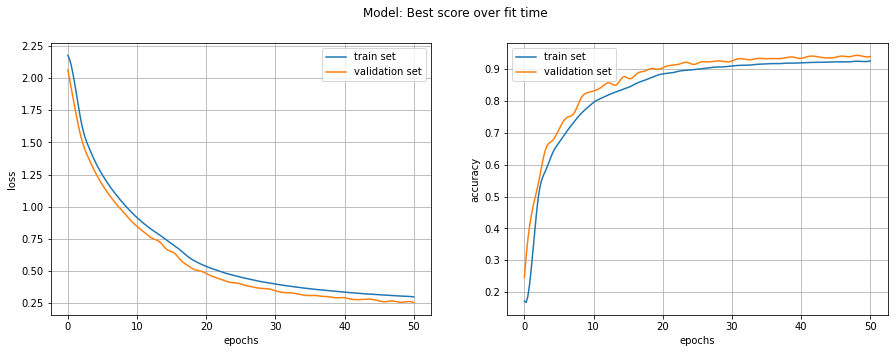

In [ ]:
plot_model("Best score over fit time", hist_ratio, test_ratio)

In [ ]:
(clf_score, hist_score, test_score) = train_test_model(X_train_pca, Y_train_tf, x_test_pca, y_test_tf, num_classes, df_score, hyper_focus=False)

Epoch 1/50
3375/3375 [==============================] - 10s 3ms/step - loss: 2.0493 - accuracy: 0.2707 - val_loss: 1.2082 - val_accuracy: 0.6815
Epoch 2/50
3375/3375 [==============================] - 9s 3ms/step - loss: 1.1628 - accuracy: 0.6888 - val_loss: 0.9391 - val_accuracy: 0.7652
Epoch 3/50
3375/3375 [==============================] - 9s 3ms/step - loss: 0.9472 - accuracy: 0.7578 - val_loss: 0.8003 - val_accuracy: 0.8077
Epoch 4/50
3375/3375 [==============================] - 9s 3ms/step - loss: 0.8175 - accuracy: 0.8031 - val_loss: 0.6985 - val_accuracy: 0.8485
Epoch 5/50
3375/3375 [==============================] - 9s 3ms/step - loss: 0.7245 - accuracy: 0.8308 - val_loss: 0.6057 - val_accuracy: 0.8812
Epoch 6/50
3375/3375 [==============================] - 9s 3ms/step - loss: 0.6477 - accuracy: 0.8517 - val_loss: 0.5638 - val_accuracy: 0.8845
Epoch 7/50
3375/3375 [==============================] - 9s 3ms/step - loss: 0.5901 - accuracy: 0.8658 - val_loss: 0.5072 - val_accuracy

Model: Best test score
Loss 0.2302 - Accuracy 0.9373


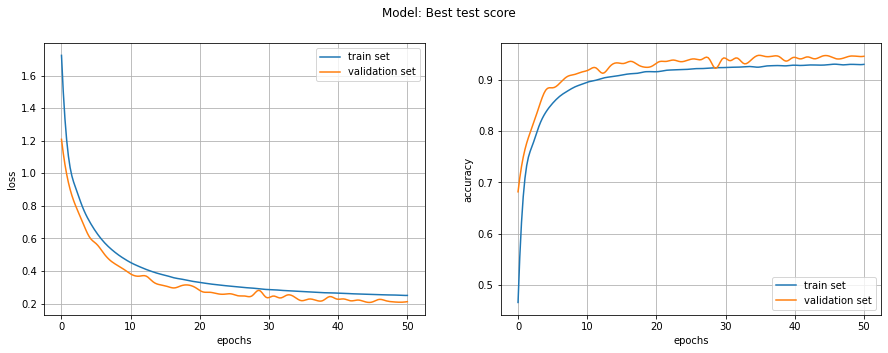

In [ ]:
plot_model("Best test score", hist_score, test_score)

### Grid Search (RBF neurons, betas)

In [ ]:
rbf_neurons = [num_classes, 2*num_classes]
betas = [0.5, 2.0]

param_grid = dict(batch_size=[64], epochs=[50], rbf_neurons=rbf_neurons, betas=betas, initializer=initializer)
grid2 = grid_search(X_train_pca, Y_train_tf, num_classes, param_grid)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] batch_size=64, betas=0.5, epochs=50, initializer=<__main__.RandomInit object at 0x7f4529b87240>, rbf_neurons=10 
Epoch 1/50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


625/625 [==============================] - 1s 2ms/step - loss: 2.2881 - accuracy: 0.1274
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 1.9979 - accuracy: 0.3697
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 1.7739 - accuracy: 0.4957
Epoch 4/50
625/625 [==============================] - 1s 2ms/step - loss: 1.5899 - accuracy: 0.5849
Epoch 5/50
625/625 [==============================] - 1s 2ms/step - loss: 1.4564 - accuracy: 0.6144
Epoch 6/50
625/625 [==============================] - 1s 2ms/step - loss: 1.3444 - accuracy: 0.6374
Epoch 7/50
625/625 [==============================] - 1s 2ms/step - loss: 1.2486 - accuracy: 0.6819
Epoch 8/50
625/625 [==============================] - 1s 2ms/step - loss: 1.1693 - accuracy: 0.7127
Epoch 9/50
625/625 [==============================] - 1s 2ms/step - loss: 1.0794 - accuracy: 0.7365
Epoch 10/50
625/625 [==============================] - 1s 2ms/step - loss: 1.0063 - accuracy: 0.7676
Epoch 11/5

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.5s remaining:    0.0s


625/625 [==============================] - 2s 2ms/step - loss: 2.2520 - accuracy: 0.1379
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 2.0012 - accuracy: 0.3828
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 1.6926 - accuracy: 0.6472
Epoch 4/50
625/625 [==============================] - 1s 2ms/step - loss: 1.4840 - accuracy: 0.7143
Epoch 5/50
625/625 [==============================] - 1s 2ms/step - loss: 1.3428 - accuracy: 0.7454
Epoch 6/50
625/625 [==============================] - 1s 2ms/step - loss: 1.2418 - accuracy: 0.7581
Epoch 7/50
625/625 [==============================] - 1s 2ms/step - loss: 1.1582 - accuracy: 0.7691
Epoch 8/50
625/625 [==============================] - 1s 2ms/step - loss: 1.0950 - accuracy: 0.7761
Epoch 9/50
625/625 [==============================] - 1s 2ms/step - loss: 1.0289 - accuracy: 0.7870
Epoch 10/50
625/625 [==============================] - 1s 2ms/step - loss: 0.9766 - accuracy: 0.7969
Epoch 11/5

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 27.2min finished


In [ ]:
df2 = pd.DataFrame(grid2.cv_results_)
df2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_betas,param_epochs,param_initializer,param_rbf_neurons,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,57.207792,0.332888,0.716863,0.011304,64,0.5,50,<__main__.RandomInit object at 0x7f4529b87240>,10,"{'batch_size': 64, 'betas': 0.5, 'epochs': 50,...",0.92045,0.91255,0.91815,0.917050,0.003318,5
1,57.932336,0.424236,0.722722,0.008454,64,0.5,50,<__main__.RandomInit object at 0x7f4529b87240>,20,"{'batch_size': 64, 'betas': 0.5, 'epochs': 50,...",0.93500,0.93375,0.93600,0.934917,0.000920,2
2,65.879739,0.511410,0.739550,0.006082,64,0.5,50,<__main__.KMeansInit object at 0x7f4529b87208>,10,"{'batch_size': 64, 'betas': 0.5, 'epochs': 50,...",0.92720,0.91960,0.93035,0.925717,0.004512,3
3,75.343498,0.274959,0.761350,0.008568,64,0.5,50,<__main__.KMeansInit object at 0x7f4529b87208>,20,"{'batch_size': 64, 'betas': 0.5, 'epochs': 50,...",0.93870,0.93450,0.94120,0.938133,0.002764,1
4,63.038154,0.185227,0.774575,0.013409,64,2,50,<__main__.RandomInit object at 0x7f4529b87240>,10,"{'batch_size': 64, 'betas': 2.0, 'epochs': 50,...",0.84585,0.75485,0.78230,0.794333,0.038113,7
5,64.639251,0.278900,0.790356,0.009593,64,2,50,<__main__.RandomInit object at 0x7f4529b87240>,20,"{'batch_size': 64, 'betas': 2.0, 'epochs': 50,...",0.91840,0.92215,0.92660,0.922383,0.003352,4
6,72.684611,0.679936,0.786440,0.027137,64,2,50,<__main__.KMeansInit object at 0x7f4529b87208>,10,"{'batch_size': 64, 'betas': 2.0, 'epochs': 50,...",0.65865,0.79895,0.78330,0.746967,0.062775,8
7,81.058974,0.593535,0.803000,0.012908,64,2,50,<__main__.KMeansInit object at 0x7f4529b87208>,20,"{'batch_size': 64, 'betas': 2.0, 'epochs': 50,...",0.91735,0.89325,0.92635,0.912317,0.013974,6


In [ ]:
df2_cmp = compact_data(df2)
df2_cmp

,RBF neurons,betas,initializer,fit time,score time,test score,score over time
0,10,0.5,<__main__.RandomInit object at 0x7f4529b87240>,57.207792,0.716863,0.917050,0.016030
1,20,0.5,<__main__.RandomInit object at 0x7f4529b87240>,57.932336,0.722722,0.934917,0.016138
2,10,0.5,<__main__.KMeansInit object at 0x7f4529b87208>,65.879739,0.739550,0.925717,0.014052
3,20,0.5,<__main__.KMeansInit object at 0x7f4529b87208>,75.343498,0.761350,0.938133,0.012451
5,20,2,<__main__.RandomInit object at 0x7f4529b87240>,64.639251,0.790356,0.922383,0.014270
7,20,2,<__main__.KMeansInit object at 0x7f4529b87208>,81.058974,0.803000,0.912317,0.011255


In [ ]:
df2_ratio = df2_cmp.sort_values(by='score over time', ascending=False)
df2_ratio

,RBF neurons,betas,initializer,fit time,score time,test score,score over time
1,20,0.5,<__main__.RandomInit object at 0x7f4529b87240>,57.932336,0.722722,0.934917,0.016138
0,10,0.5,<__main__.RandomInit object at 0x7f4529b87240>,57.207792,0.716863,0.917050,0.016030
5,20,2,<__main__.RandomInit object at 0x7f4529b87240>,64.639251,0.790356,0.922383,0.014270
2,10,0.5,<__main__.KMeansInit object at 0x7f4529b87208>,65.879739,0.739550,0.925717,0.014052
3,20,0.5,<__main__.KMeansInit object at 0x7f4529b87208>,75.343498,0.761350,0.938133,0.012451
7,20,2,<__main__.KMeansInit object at 0x7f4529b87208>,81.058974,0.803000,0.912317,0.011255


In [ ]:
df2_score = df2_cmp.sort_values(by='test score', ascending=False)
df2_score

,RBF neurons,betas,initializer,fit time,score time,test score,score over time
3,20,0.5,<__main__.KMeansInit object at 0x7f4529b87208>,75.343498,0.761350,0.938133,0.012451
1,20,0.5,<__main__.RandomInit object at 0x7f4529b87240>,57.932336,0.722722,0.934917,0.016138
2,10,0.5,<__main__.KMeansInit object at 0x7f4529b87208>,65.879739,0.739550,0.925717,0.014052
5,20,2,<__main__.RandomInit object at 0x7f4529b87240>,64.639251,0.790356,0.922383,0.014270
0,10,0.5,<__main__.RandomInit object at 0x7f4529b87240>,57.207792,0.716863,0.917050,0.016030
7,20,2,<__main__.KMeansInit object at 0x7f4529b87208>,81.058974,0.803000,0.912317,0.011255


In [ ]:
(clf_ratio2, hist_ratio2, test_ratio2) = train_test_model(X_train_pca, Y_train_tf, x_test_pca, y_test_tf, num_classes, df2_ratio)

Epoch 1/50
844/844 [==============================] - 3s 3ms/step - loss: 2.1666 - accuracy: 0.1612 - val_loss: 1.5346 - val_accuracy: 0.5940
Epoch 2/50
844/844 [==============================] - 2s 3ms/step - loss: 1.4599 - accuracy: 0.6432 - val_loss: 1.2149 - val_accuracy: 0.7872
Epoch 3/50
844/844 [==============================] - 2s 3ms/step - loss: 1.1906 - accuracy: 0.7581 - val_loss: 0.9933 - val_accuracy: 0.8432
Epoch 4/50
844/844 [==============================] - 2s 3ms/step - loss: 0.9999 - accuracy: 0.8033 - val_loss: 0.8277 - val_accuracy: 0.8625
Epoch 5/50
844/844 [==============================] - 2s 3ms/step - loss: 0.8446 - accuracy: 0.8342 - val_loss: 0.7137 - val_accuracy: 0.8788
Epoch 6/50
844/844 [==============================] - 2s 3ms/step - loss: 0.7456 - accuracy: 0.8501 - val_loss: 0.6264 - val_accuracy: 0.8897
Epoch 7/50
844/844 [==============================] - 2s 3ms/step - loss: 0.6597 - accuracy: 0.8657 - val_loss: 0.5510 - val_accuracy: 0.8980
Epoch 

Model: Best score over fit time
Loss 0.2022 - Accuracy 0.9453


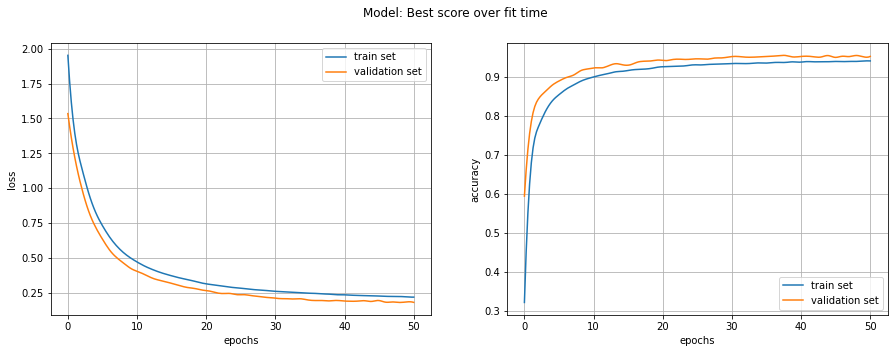

In [ ]:
plot_model("Best score over fit time", hist_ratio2, test_ratio2)

In [ ]:
(clf_score2, hist_score2, test_score2) = train_test_model(X_train_pca, Y_train_tf, x_test_pca, y_test_tf, num_classes, df2_score)

Epoch 1/50
844/844 [==============================] - 3s 3ms/step - loss: 2.1022 - accuracy: 0.3101 - val_loss: 1.2984 - val_accuracy: 0.7952
Epoch 2/50
844/844 [==============================] - 2s 3ms/step - loss: 1.2296 - accuracy: 0.7825 - val_loss: 0.9410 - val_accuracy: 0.8613
Epoch 3/50
844/844 [==============================] - 2s 3ms/step - loss: 0.9301 - accuracy: 0.8337 - val_loss: 0.7471 - val_accuracy: 0.8823
Epoch 4/50
844/844 [==============================] - 2s 3ms/step - loss: 0.7748 - accuracy: 0.8545 - val_loss: 0.6407 - val_accuracy: 0.8960
Epoch 5/50
844/844 [==============================] - 2s 3ms/step - loss: 0.6753 - accuracy: 0.8693 - val_loss: 0.5706 - val_accuracy: 0.8925
Epoch 6/50
844/844 [==============================] - 2s 3ms/step - loss: 0.6030 - accuracy: 0.8822 - val_loss: 0.4981 - val_accuracy: 0.9102
Epoch 7/50
844/844 [==============================] - 2s 3ms/step - loss: 0.5434 - accuracy: 0.8928 - val_loss: 0.4496 - val_accuracy: 0.9195
Epoch 

Model: Best test score
Loss 0.1935 - Accuracy 0.9438


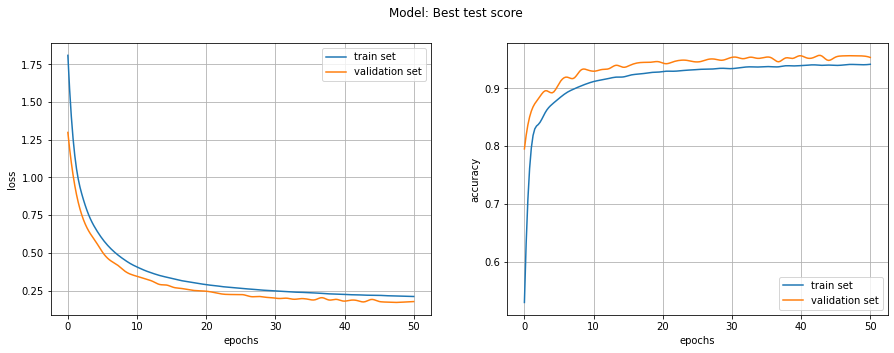

In [ ]:
plot_model("Best test score", hist_score2, test_score2)

## Odd vs Even Numbers

### Transforming

In [ ]:
def transform(Y_train, y_test):
    assert type(Y_train) == np.ndarray
    assert type(y_test) == np.ndarray

    Y_train_parity = Y_train.copy()
    y_test_parity = y_test.copy()

    Y_train_parity[Y_train_parity % 2 == 0] = 0
    Y_train_parity[Y_train_parity % 2 == 1] = 1

    y_test_parity[y_test_parity % 2 == 0] = 0
    y_test_parity[y_test_parity % 2 == 1] = 1

    return Y_train_parity, y_test_parity

In [ ]:
Y_train_parity, y_test_parity = transform(Y_train, y_test)

### Neighbor models

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn1 = KNeighborsClassifier(1, n_jobs=-1)
knn1.fit(X_train_pca, Y_train_parity)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
knn1.score(x_test_pca, y_test_parity)

0.991

In [ ]:
knn3 = KNeighborsClassifier(3, n_jobs=-1)
knn3.fit(X_train_pca, Y_train_parity)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
knn3.score(x_test_pca, y_test_parity)

0.9917

#### Nearest Centroid

In [ ]:
from sklearn.neighbors import NearestCentroid

nc = NearestCentroid()
nc.fit(X_train_pca, Y_train_parity)

NearestCentroid(metric='euclidean', shrink_threshold=None)

In [ ]:
nc.score(x_test_pca, y_test_parity)

0.7998

### RBF NNs

#### Variables

In [ ]:
num_classes_parity = 2
Y_train_parity_tf = keras.utils.to_categorical(Y_train_parity, num_classes_parity)
y_test_parity_tf = keras.utils.to_categorical(y_test_parity, num_classes_parity)

In [ ]:
rInit = RandomInit(X_train_pca)
kmInit = KMeansInit(X_train_pca)
initializer = [rInit, kmInit]

#### Grid Search (batch size, epochs)

In [ ]:
batch_size = [16, 32, 64]
epochs = [25, 50]

param_grid = dict(batch_size=batch_size, epochs=epochs, initializer=initializer)
grid_parity = grid_search(X_train_pca, Y_train_parity, num_classes_parity, param_grid)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] batch_size=16, epochs=25, initializer=<__main__.RandomInit object at 0x7f6d3c1a4dd8> 
Epoch 1/25


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2500/2500 [==============================] - 7s 2ms/step - loss: 0.6931 - accuracy: 0.5066
Epoch 2/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6931 - accuracy: 0.5047
Epoch 3/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6787 - accuracy: 0.5497
Epoch 4/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.5773 - accuracy: 0.7797
Epoch 5/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.5130 - accuracy: 0.8210
Epoch 6/25
2500/2500 [==============================] - 6s 3ms/step - loss: 0.4716 - accuracy: 0.8387
Epoch 7/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.4443 - accuracy: 0.8437
Epoch 8/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.4236 - accuracy: 0.8482
Epoch 9/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.4027 - accuracy: 0.8604
Epoch 10/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.3883 - accurac

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s


2500/2500 [==============================] - 7s 2ms/step - loss: 0.6931 - accuracy: 0.5076
Epoch 2/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6931 - accuracy: 0.5089
Epoch 3/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6931 - accuracy: 0.5073
Epoch 4/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6931 - accuracy: 0.5068
Epoch 5/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6931 - accuracy: 0.5079
Epoch 6/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.6836 - accuracy: 0.5298
Epoch 7/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.5434 - accuracy: 0.7860
Epoch 8/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.4516 - accuracy: 0.8332
Epoch 9/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.4134 - accuracy: 0.8416
Epoch 10/25
2500/2500 [==============================] - 6s 2ms/step - loss: 0.3890 - accurac

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 84.2min finished


In [ ]:
df_parity = pd.DataFrame(grid_parity.cv_results_)
df_parity

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_epochs,param_initializer,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,153.639408,0.223310,2.784436,0.026962,16,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 16, 'epochs': 25, 'initializer'...",0.88295,0.90130,0.89035,0.891533,0.007538,8
1,157.129317,0.813264,2.797191,0.015713,16,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 16, 'epochs': 25, 'initializer'...",0.91050,0.90035,0.91350,0.908117,0.005627,3
2,317.523097,2.303199,2.876372,0.015042,16,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 16, 'epochs': 50, 'initializer'...",0.92865,0.90200,0.92080,0.917150,0.011182,2
3,334.979241,6.348323,2.999829,0.064819,16,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 16, 'epochs': 50, 'initializer'...",0.90035,0.91875,0.89485,0.904650,0.010220,4
4,78.560782,2.180535,1.447406,0.011637,32,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 32, 'epochs': 25, 'initializer'...",0.88595,0.88195,0.88560,0.884500,0.001809,10
5,78.369956,0.540179,1.449498,0.011901,32,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 32, 'epochs': 25, 'initializer'...",0.88430,0.89025,0.88985,0.888133,0.002716,9
6,152.291461,0.632994,1.444173,0.005980,32,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 32, 'epochs': 50, 'initializer'...",0.89840,0.89840,0.89805,0.898283,0.000165,6
7,154.996192,1.160199,1.456715,0.011997,32,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 32, 'epochs': 50, 'initializer'...",0.91825,0.91735,0.91830,0.917967,0.000437,1
8,38.935067,0.077939,0.973973,0.015326,64,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,"{'batch_size': 64, 'epochs': 25, 'initializer'...",0.87375,0.50750,0.87945,0.753567,0.174011,12
9,40.816003,0.032947,0.963154,0.013247,64,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,"{'batch_size': 64, 'epochs': 25, 'initializer'...",0.87890,0.87720,0.88000,0.878700,0.001152,11


In [ ]:
df_cmp_parity = compact_data(df_parity, hyper_focus=False, score_threshold=0.89)
df_cmp_parity

,batch size,epochs,initializer,fit time,score time,test score,score over time
0,16,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,153.639408,2.784436,0.891533,0.005803
1,16,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,157.129317,2.797191,0.908117,0.005779
2,16,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,317.523097,2.876372,0.917150,0.002888
3,16,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,334.979241,2.999829,0.904650,0.002701
6,32,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,152.291461,1.444173,0.898283,0.005898
7,32,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,154.996192,1.456715,0.917967,0.005923
10,64,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,77.334820,0.969172,0.898583,0.011619
11,64,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,79.055951,0.974524,0.892467,0.011289


In [ ]:
df_parity_ratio = df_cmp_parity.sort_values(by='score over time', ascending=False)
df_parity_ratio

,batch size,epochs,initializer,fit time,score time,test score,score over time
10,64,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,77.334820,0.969172,0.898583,0.011619
11,64,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,79.055951,0.974524,0.892467,0.011289
7,32,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,154.996192,1.456715,0.917967,0.005923
6,32,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,152.291461,1.444173,0.898283,0.005898
0,16,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,153.639408,2.784436,0.891533,0.005803
1,16,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,157.129317,2.797191,0.908117,0.005779
2,16,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,317.523097,2.876372,0.917150,0.002888
3,16,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,334.979241,2.999829,0.904650,0.002701


In [ ]:
df_parity_score = df_cmp_parity.sort_values(by='test score', ascending=False)
df_parity_score

,batch size,epochs,initializer,fit time,score time,test score,score over time
7,32,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,154.996192,1.456715,0.917967,0.005923
2,16,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,317.523097,2.876372,0.917150,0.002888
1,16,25,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,157.129317,2.797191,0.908117,0.005779
3,16,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,334.979241,2.999829,0.904650,0.002701
10,64,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,77.334820,0.969172,0.898583,0.011619
6,32,50,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,152.291461,1.444173,0.898283,0.005898
11,64,50,<__main__.KMeansInit object at 0x7f6d3c1a4da0>,79.055951,0.974524,0.892467,0.011289
0,16,25,<__main__.RandomInit object at 0x7f6d3c1a4dd8>,153.639408,2.784436,0.891533,0.005803


In [ ]:
(clf_parity_ratio, hist_parity_ratio, test_parity_ratio) = train_test_model(X_train_pca, Y_train_parity_tf, x_test_pca, y_test_parity_tf, num_classes_parity, df_parity_ratio, hyper_focus=False)

Epoch 1/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.6600 - accuracy: 0.5794 - val_loss: 0.5481 - val_accuracy: 0.7670
Epoch 2/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.5127 - accuracy: 0.7863 - val_loss: 0.4376 - val_accuracy: 0.8228
Epoch 3/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.4266 - accuracy: 0.8364 - val_loss: 0.3783 - val_accuracy: 0.8633
Epoch 4/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3796 - accuracy: 0.8584 - val_loss: 0.3489 - val_accuracy: 0.8717
Epoch 5/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3505 - accuracy: 0.8679 - val_loss: 0.3234 - val_accuracy: 0.8875
Epoch 6/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3340 - accuracy: 0.8730 - val_loss: 0.3043 - val_accuracy: 0.8943
Epoch 7/50
1688/1688 [==============================] - 4s 3ms/step - loss: 0.3183 - accuracy: 0.8812 - val_loss: 0.3024 - val_accuracy:

Model: Best score over fit time
Loss 0.1926 - Accuracy 0.9288


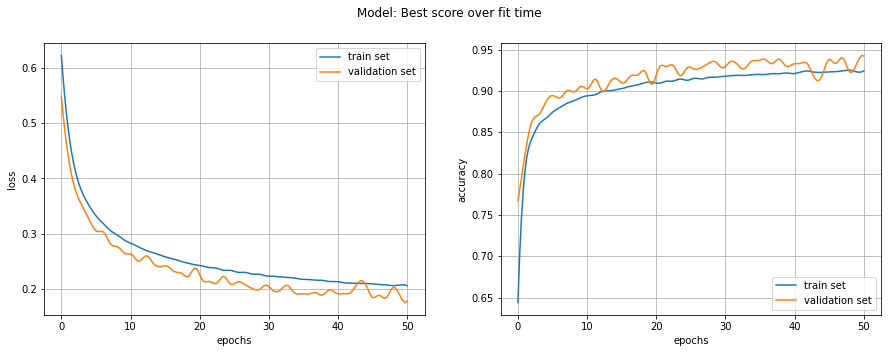

In [ ]:
plot_model("Best score over fit time", hist_parity_ratio, test_parity_ratio)

In [ ]:
(clf_parity_score, hist_parity_score, test_parity_score) = train_test_model(X_train_pca, Y_train_parity_tf, x_test_pca, y_test_parity_tf, num_classes_parity, df_parity_score, hyper_focus=False)

Epoch 1/50
844/844 [==============================] - 3s 3ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6930 - val_accuracy: 0.5083
Epoch 2/50
844/844 [==============================] - 2s 3ms/step - loss: 0.6931 - accuracy: 0.5074 - val_loss: 0.6930 - val_accuracy: 0.5083
Epoch 3/50
844/844 [==============================] - 2s 3ms/step - loss: 0.6918 - accuracy: 0.5127 - val_loss: 0.6283 - val_accuracy: 0.7077
Epoch 4/50
844/844 [==============================] - 2s 3ms/step - loss: 0.5977 - accuracy: 0.7266 - val_loss: 0.5368 - val_accuracy: 0.7822
Epoch 5/50
844/844 [==============================] - 2s 3ms/step - loss: 0.5246 - accuracy: 0.7728 - val_loss: 0.4943 - val_accuracy: 0.8007
Epoch 6/50
844/844 [==============================] - 2s 3ms/step - loss: 0.4920 - accuracy: 0.7937 - val_loss: 0.4657 - val_accuracy: 0.8207
Epoch 7/50
844/844 [==============================] - 2s 3ms/step - loss: 0.4659 - accuracy: 0.8087 - val_loss: 0.4252 - val_accuracy: 0.8577
Epoch 

Model: Best test score
Loss 0.2093 - Accuracy 0.9171


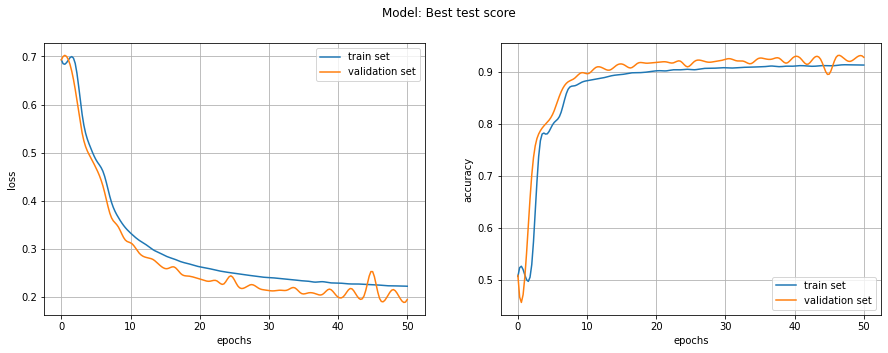

In [ ]:
plot_model("Best test score", hist_parity_score, test_parity_score)

#### Grid Search (RBF neurons, betas)

In [ ]:
rbf_neurons = [num_classes_parity, 10*num_classes_parity]
betas = [0.1, 5.0]

param_grid = dict(batch_size=[64], epochs=[50], rbf_neurons=rbf_neurons, betas=betas, initializer=initializer)
grid2_parity = grid_search(X_train_pca, Y_train_parity_tf, num_classes_parity, param_grid)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] batch_size=64, betas=0.1, epochs=50, initializer=<__main__.RandomInit object at 0x7f44ce5e5828>, rbf_neurons=2 
Epoch 1/50


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


625/625 [==============================] - 1s 2ms/step - loss: 0.7010 - accuracy: 0.4346
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5026
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.4977
Epoch 4/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5078
Epoch 5/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5060
Epoch 6/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5035
Epoch 7/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.5128
Epoch 8/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5079
Epoch 9/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5076
Epoch 10/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5099
Epoch 11/5

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   57.5s remaining:    0.0s


625/625 [==============================] - 1s 2ms/step - loss: 0.6939 - accuracy: 0.4921
Epoch 2/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5089
Epoch 3/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5105
Epoch 4/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5092
Epoch 5/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5046
Epoch 6/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5066
Epoch 7/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6929 - accuracy: 0.5116
Epoch 8/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5082
Epoch 9/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6931 - accuracy: 0.5081
Epoch 10/50
625/625 [==============================] - 1s 2ms/step - loss: 0.6930 - accuracy: 0.5102
Epoch 11/5

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 26.5min finished


In [ ]:
df2_parity = pd.DataFrame(grid2_parity.cv_results_)
df2_parity

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_betas,param_epochs,param_initializer,param_rbf_neurons,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,56.578012,0.189012,0.705282,0.004284,64,0.1,50,<__main__.RandomInit object at 0x7f44ce5e5828>,2,"{'batch_size': 64, 'betas': 0.1, 'epochs': 50,...",0.51195,0.90285,0.91175,0.775517,0.186405,6
1,57.716410,0.290486,0.719308,0.003386,64,0.1,50,<__main__.RandomInit object at 0x7f44ce5e5828>,20,"{'batch_size': 64, 'betas': 0.1, 'epochs': 50,...",0.96600,0.96665,0.96445,0.965700,0.000923,2
2,60.995164,0.856290,0.752249,0.020585,64,0.1,50,<__main__.KMeansInit object at 0x7f44ce5e5f98>,2,"{'batch_size': 64, 'betas': 0.1, 'epochs': 50,...",0.91145,0.90880,0.91465,0.911633,0.002392,4
3,75.394608,0.695020,0.760857,0.008912,64,0.1,50,<__main__.KMeansInit object at 0x7f44ce5e5f98>,20,"{'batch_size': 64, 'betas': 0.1, 'epochs': 50,...",0.96820,0.96895,0.96540,0.967517,0.001528,1
4,62.836742,0.310276,0.779238,0.009371,64,5,50,<__main__.RandomInit object at 0x7f44ce5e5828>,2,"{'batch_size': 64, 'betas': 5.0, 'epochs': 50,...",0.51195,0.50750,0.50595,0.508467,0.002543,7
5,64.220709,0.731252,0.786626,0.059653,64,5,50,<__main__.RandomInit object at 0x7f44ce5e5828>,20,"{'batch_size': 64, 'betas': 5.0, 'epochs': 50,...",0.91040,0.91650,0.91630,0.914400,0.002830,3
6,67.005769,0.324245,0.811747,0.014418,64,5,50,<__main__.KMeansInit object at 0x7f44ce5e5f98>,2,"{'batch_size': 64, 'betas': 5.0, 'epochs': 50,...",0.51195,0.50750,0.50595,0.508467,0.002543,7
7,79.744166,0.879126,0.801900,0.026926,64,5,50,<__main__.KMeansInit object at 0x7f44ce5e5f98>,20,"{'batch_size': 64, 'betas': 5.0, 'epochs': 50,...",0.89075,0.88500,0.89475,0.890167,0.004002,5


In [ ]:
df2_parity_cmp = compact_data(df2_parity)
df2_parity_cmp

,RBF neurons,betas,initializer,fit time,score time,test score,score over time
1,20,0.1,<__main__.RandomInit object at 0x7f44ce5e5828>,57.716410,0.719308,0.965700,0.016732
2,2,0.1,<__main__.KMeansInit object at 0x7f44ce5e5f98>,60.995164,0.752249,0.911633,0.014946
3,20,0.1,<__main__.KMeansInit object at 0x7f44ce5e5f98>,75.394608,0.760857,0.967517,0.012833
5,20,5,<__main__.RandomInit object at 0x7f44ce5e5828>,64.220709,0.786626,0.914400,0.014238


In [ ]:
df2_parity_ratio = df2_parity_cmp.sort_values(by='score over time', ascending=False)
df2_parity_ratio

,RBF neurons,betas,initializer,fit time,score time,test score,score over time
1,20,0.1,<__main__.RandomInit object at 0x7f44ce5e5828>,57.716410,0.719308,0.965700,0.016732
2,2,0.1,<__main__.KMeansInit object at 0x7f44ce5e5f98>,60.995164,0.752249,0.911633,0.014946
5,20,5,<__main__.RandomInit object at 0x7f44ce5e5828>,64.220709,0.786626,0.914400,0.014238
3,20,0.1,<__main__.KMeansInit object at 0x7f44ce5e5f98>,75.394608,0.760857,0.967517,0.012833


In [ ]:
df2_parity_score = df2_parity_cmp.sort_values(by='test score', ascending=False)
df2_parity_score

,RBF neurons,betas,initializer,fit time,score time,test score,score over time
3,20,0.1,<__main__.KMeansInit object at 0x7f44ce5e5f98>,75.394608,0.760857,0.967517,0.012833
1,20,0.1,<__main__.RandomInit object at 0x7f44ce5e5828>,57.716410,0.719308,0.965700,0.016732
5,20,5,<__main__.RandomInit object at 0x7f44ce5e5828>,64.220709,0.786626,0.914400,0.014238
2,2,0.1,<__main__.KMeansInit object at 0x7f44ce5e5f98>,60.995164,0.752249,0.911633,0.014946


In [ ]:
(clf_parity_ratio2, hist_parity_ratio2, test_parity_ratio2) = train_test_model(X_train_pca, Y_train_parity_tf, x_test_pca, y_test_parity_tf, num_classes_parity, df2_parity_ratio)

Epoch 1/50
844/844 [==============================] - 3s 3ms/step - loss: 0.5741 - accuracy: 0.7500 - val_loss: 0.3592 - val_accuracy: 0.8775
Epoch 2/50
844/844 [==============================] - 2s 3ms/step - loss: 0.3414 - accuracy: 0.8818 - val_loss: 0.2618 - val_accuracy: 0.9108
Epoch 3/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2670 - accuracy: 0.9033 - val_loss: 0.2163 - val_accuracy: 0.9282
Epoch 4/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2357 - accuracy: 0.9136 - val_loss: 0.2006 - val_accuracy: 0.9310
Epoch 5/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2203 - accuracy: 0.9179 - val_loss: 0.1842 - val_accuracy: 0.9350
Epoch 6/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2068 - accuracy: 0.9239 - val_loss: 0.1784 - val_accuracy: 0.9360
Epoch 7/50
844/844 [==============================] - 2s 3ms/step - loss: 0.1966 - accuracy: 0.9282 - val_loss: 0.1716 - val_accuracy: 0.9395
Epoch 

Model: Best score over fit time (parity)
Loss 0.0954 - Accuracy 0.9687


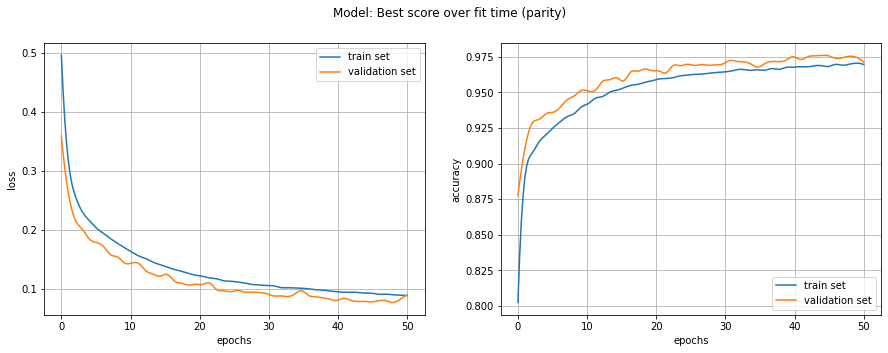

In [ ]:
plot_model("Best score over fit time (parity)", hist_parity_ratio2, test_parity_ratio2)

In [ ]:
(clf_parity_score2, hist_parity_score2, test_parity_score2) = train_test_model(X_train_pca, Y_train_parity_tf, x_test_pca, y_test_parity_tf, num_classes_parity, df2_parity_score)

Epoch 1/50
844/844 [==============================] - 3s 3ms/step - loss: 0.5753 - accuracy: 0.7241 - val_loss: 0.3393 - val_accuracy: 0.8945
Epoch 2/50
844/844 [==============================] - 2s 3ms/step - loss: 0.3245 - accuracy: 0.8912 - val_loss: 0.2423 - val_accuracy: 0.9208
Epoch 3/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2486 - accuracy: 0.9138 - val_loss: 0.1972 - val_accuracy: 0.9360
Epoch 4/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2167 - accuracy: 0.9239 - val_loss: 0.1784 - val_accuracy: 0.9407
Epoch 5/50
844/844 [==============================] - 2s 3ms/step - loss: 0.2023 - accuracy: 0.9271 - val_loss: 0.1679 - val_accuracy: 0.9447
Epoch 6/50
844/844 [==============================] - 2s 3ms/step - loss: 0.1874 - accuracy: 0.9327 - val_loss: 0.1597 - val_accuracy: 0.9472
Epoch 7/50
844/844 [==============================] - 2s 3ms/step - loss: 0.1785 - accuracy: 0.9375 - val_loss: 0.1644 - val_accuracy: 0.9447
Epoch 

Model: Best test score (parity)
Loss 0.0917 - Accuracy 0.9680


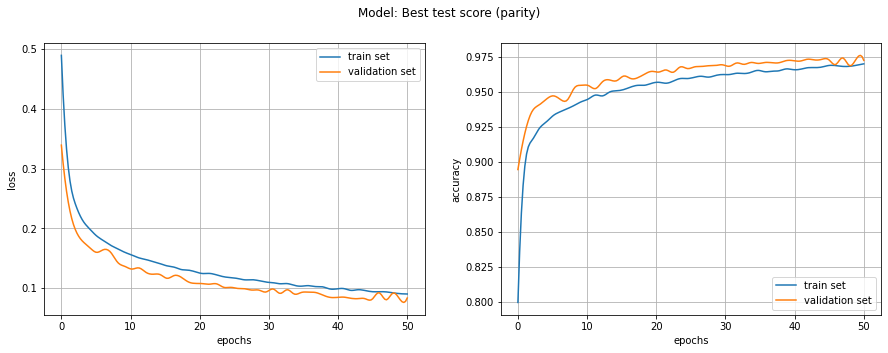

In [ ]:
plot_model("Best test score (parity)", hist_parity_score2, test_parity_score2)

## Visualizing Results

In [ ]:
def get_predictions(models, y, i):
  labels = [y_test[i] for y_test in y]
  predictions = [np.argmax(clf.predict(np.array([x_test_pca[i]]))) for clf in models]
  return labels, predictions

def check_match(models, y, i):
  labels, predictions = get_predictions(models, y, i)
  return tuple(np.equal(labels, predictions))

In [ ]:
clf = [clf_ratio2, clf_parity_ratio2]
y = [y_test, y_test_parity]

In [ ]:
def fill(arr, index, value):
  arr[index] = arr[index] if arr[index] else value

# found[0]: both right
# found[1]: digit right, parity wrong
# found[2]: digit wrong, parity right
# found[3]: both wrong
found = [False] * 4

for i in range(len(x_test_pca)):
  (digit_match, parity_match) = check_match(clf, y, i)

  if digit_match and parity_match:
    fill(found, 0, i)
  elif digit_match:
    fill(found, 1, i)
  elif parity_match:
    fill(found, 2, i)
  else:
    fill(found, 3, i)

  if np.all(found):
    break

----------
Example #0
----------
-= Digit Model =-
Actual:    2
Predicted: 2

-= Parity Model =-
Actual:    even
Predicted: even

----------
Example #1
----------
-= Digit Model =-
Actual:    2
Predicted: 2

-= Parity Model =-
Actual:    even
Predicted: odd

----------
Example #2
----------
-= Digit Model =-
Actual:    4
Predicted: 6

-= Parity Model =-
Actual:    even
Predicted: even

----------
Example #3
----------
-= Digit Model =-
Actual:    2
Predicted: 3

-= Parity Model =-
Actual:    even
Predicted: odd



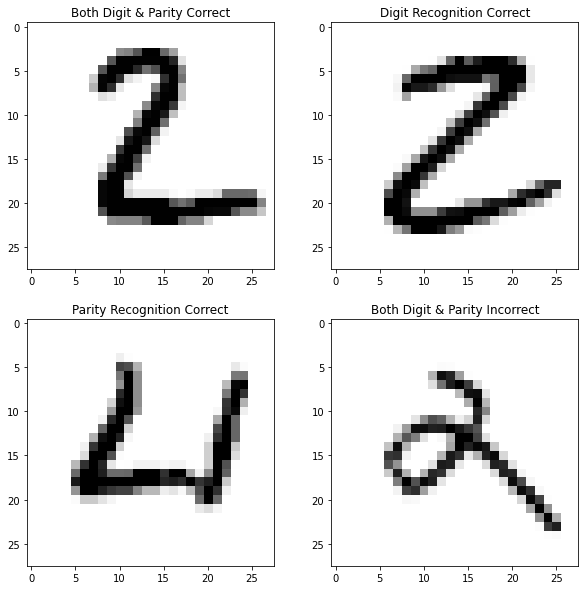

In [ ]:
def get_label(label, isParity):
  return ("odd" if label else "even") if isParity else str(label)

fig, axs = plt.subplots(2, 2, figsize=(10,10))

((both, digit), (parity, neither)) = axs

both.set_title("Both Digit & Parity Correct")
digit.set_title("Digit Recognition Correct")
parity.set_title("Parity Recognition Correct")
neither.set_title("Both Digit & Parity Incorrect")

axs = axs.flatten()

isParity = [1 == np.max(y_test) for y_test in y]

for i in range(4):
  print("-" * 10)
  print("Example #%d" % i)
  print("-" * 10)
  index = found[i]

  labels, predictions = get_predictions(clf, y, index)
  for j in range(len(labels)):
    print("-= %s Model =-" % ("Parity" if isParity[j] else "Digit"))

    label = get_label(labels[j], isParity[j])
    prediction = get_label(predictions[j], isParity[j])
    print("Actual:    %s" % label)
    print("Predicted: %s\n" % prediction)

  digit = x_test[index].reshape(28,28)
  axs[i].imshow(digit, cmap='gray_r')